In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import matplotlib as mpl
import warnings
import glob

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')


# df_fleats = pd.read_csv('data/marketing-breakdown-detailed.csv')
# df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (2).csv'))
# df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (3).csv'))
# df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (4).csv'))
# read whole year data
allFiles = glob.glob("data/*.csv")
df_fleats = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,parse_dates=False)
    list_.append(df)
df_fleats = pd.concat(list_)

In [2]:
selected_features = ['Marketing Code','Suburb', 'State','Post Code','Classification','Enquired',
                     'Loan Amount','loan_reason','property_use']
target = 'Enquiry Status';
whole_set = selected_features + [target]

df = df_fleats[whole_set]
df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['Loan Amount'] = pd.to_numeric(df['Loan Amount'],errors='coerce')
df = df.dropna(axis=0, how='any')
df = df[~df[target].isin(['In Progress','Just Received'])]

In [3]:
df['Enquired'] = pd.DatetimeIndex(df['Enquired'])
df['Loan Amount'] = df['Loan Amount'].astype(int)
df['Post Code'] = df['Post Code'].astype(int)

In [4]:
from datetime import datetime
from dateutil.parser import parse

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['Enquired'] > start_date) & (df['Enquired'] <= end_date)
df = df.loc[mask].reset_index(drop=True)

# remove Year feature since it is not important (show below random forest)
# df['Year'] = df['Enquired'].dt.year
df['Month'] = df['Enquired'].dt.month
df['Day'] = df['Enquired'].dt.day
df['Hour'] = df['Enquired'].dt.hour
df['Weekday'] = df['Enquired'].dt.weekday_name

df = df.loc[:,df.columns != 'Enquiried']

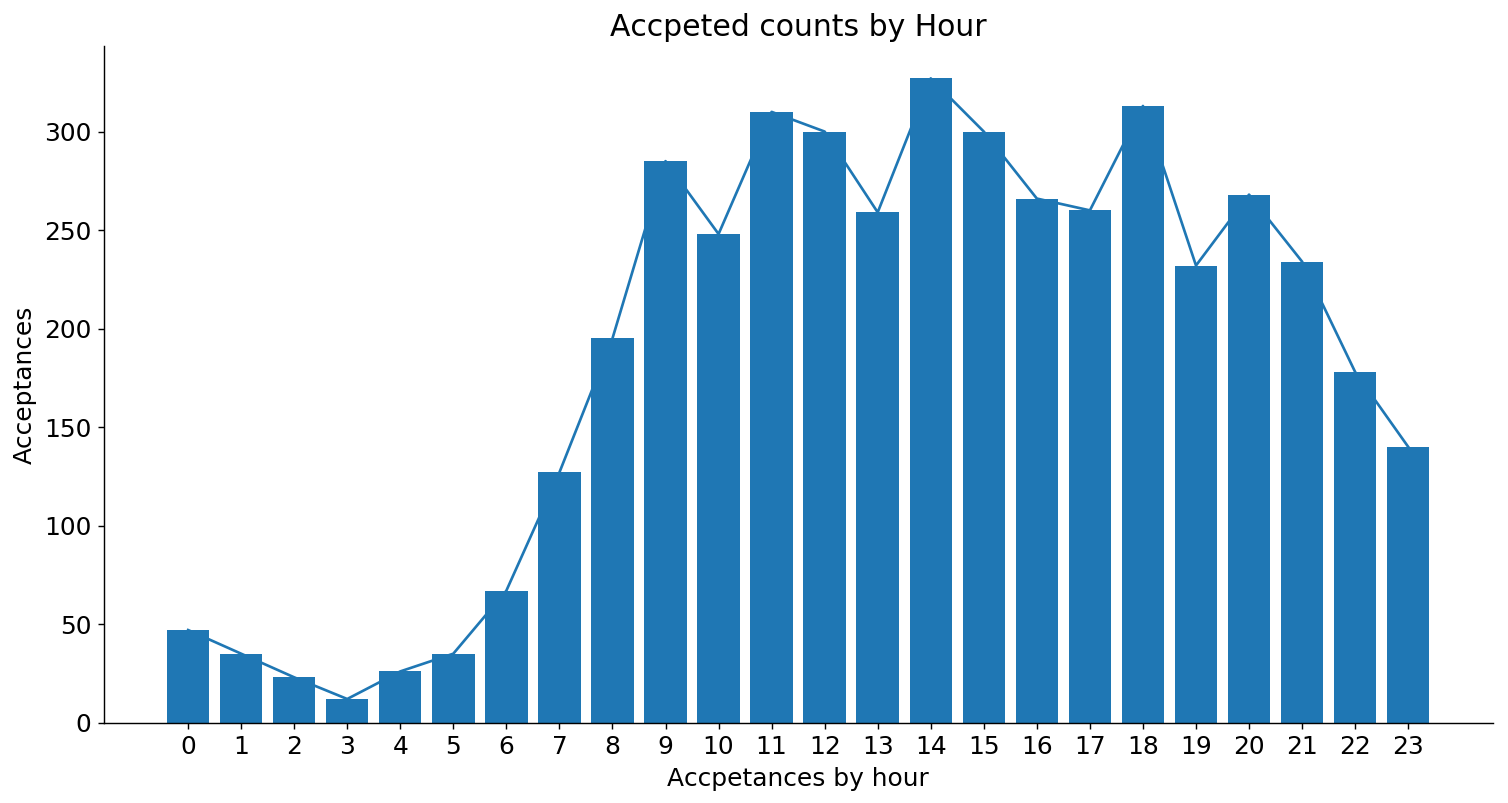

In [5]:
import random
import matplotlib.dates as mdates
import matplotlib.mlab as mlab

# generate some random data (approximately over 5 years)
data_1 = df[['Enquiry Status','Day']]
data_2 = df[['Enquiry Status','Hour']]

plot_date = data_1.groupby(['Day', 'Enquiry Status']).size().reset_index(name="counts")
plot_date = plot_date.loc[plot_date['Enquiry Status'] == 'Accepted']

plot_time = data_2.groupby(['Hour', 'Enquiry Status']).size().reset_index(name="counts")
plot_time = plot_time.loc[plot_time['Enquiry Status'] == 'Accepted']

plt.xlabel('Accpetances by hour')
plt.ylabel('Acceptances')
plt.plot(plot_time['Hour'], plot_time['counts'])

plt.title('Accpeted counts by Hour')
plt.bar(range(plot_time['Hour'].shape[0]), plot_time['counts'])
plt.xticks(range(plot_time['Hour'].shape[0]),plot_time['Hour'].values)
# plt.xticks(rotation=90)
plt.show()

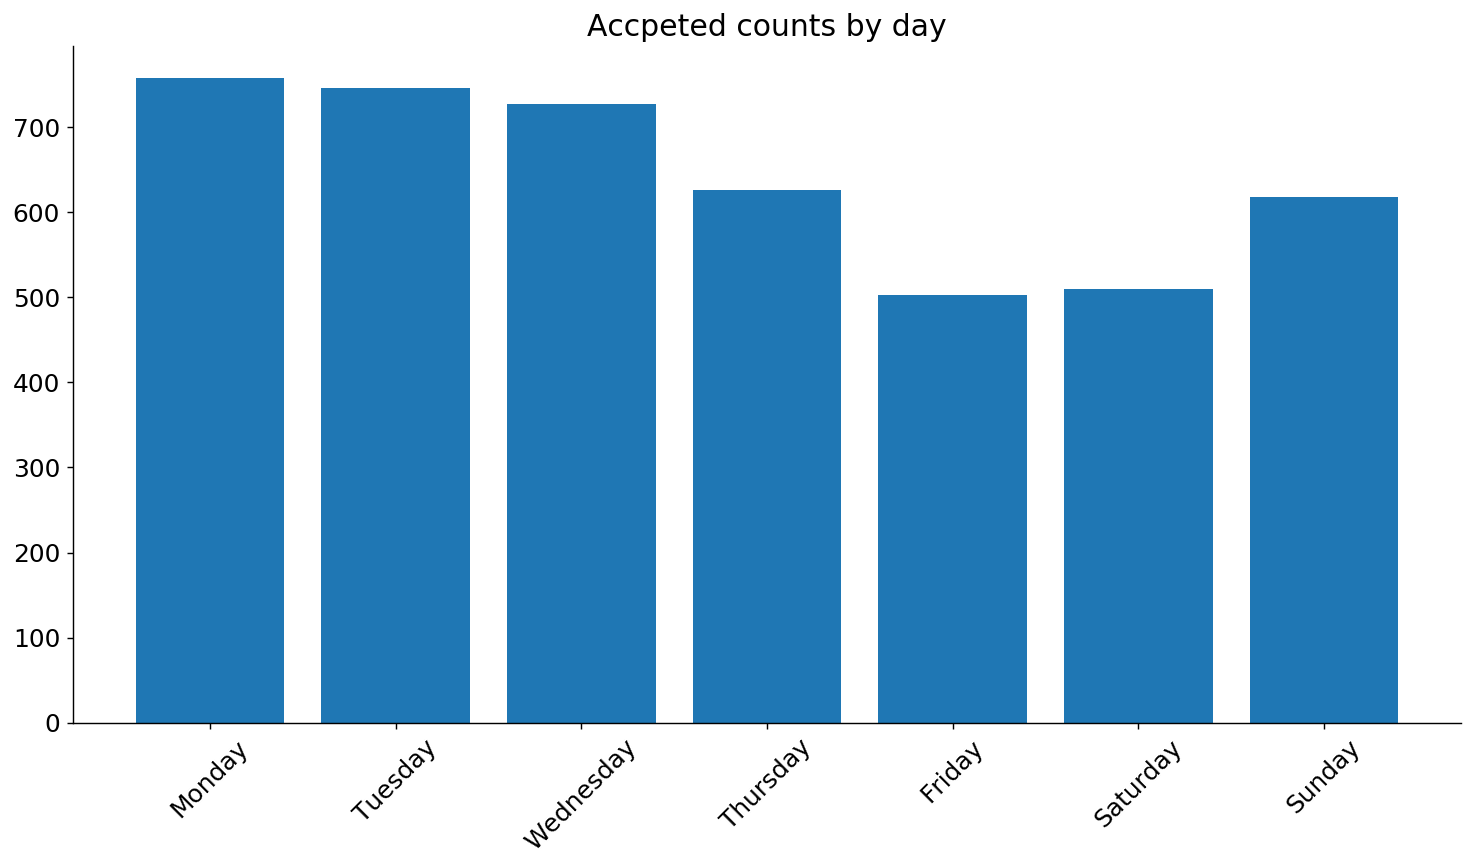

In [6]:
import calendar

plt_accepted = df.loc[df['Enquiry Status'] == 'Accepted']

# get and sort acceptances by day
count_day_accepted = plt_accepted.groupby(['Weekday']).size().reset_index(name="counts")
weekdays = list(calendar.day_name)
mapping = {day: i for i, day in enumerate(weekdays)}
key = count_day_accepted['Weekday'].map(mapping)
count_day_accepted = count_day_accepted.iloc[key.argsort()].reset_index(drop=True)


plt_rejected = df.loc[df['Enquiry Status'] == 'Rejected']

count_day_rejected = plt_rejected.groupby(['Weekday']).size().reset_index(name="counts")
weekdays = list(calendar.day_name)
mapping = {day: i for i, day in enumerate(weekdays)}
key = count_day_rejected['Weekday'].map(mapping)
count_day_rejected = count_day_rejected.iloc[key.argsort()].reset_index(drop=True)



plt_X1 = plt_accepted[['Loan Amount','Weekday']]
plt_y1 = plt_accepted[['Enquiry Status']]

# ax = count_day.plot()
# ax.set_xlabel("Day")
# plt.plot_date(x=count_day['day_of_week'], y=count_day['counts'],fmt="r-")
# plt.plot_date(x=count_date['Enquired Date'], y=count_date['counts'],fmt="r-")

# plt.plot(count_day_accepted['day_of_week'], count_day_accepted['counts'])
# plt.xticks(rotation=45)
# plt.show()

# print(count_day_accepted['day_of_week'].shape[0])
plt.title('Accpeted counts by day')
plt.bar(range(count_day_accepted['Weekday'].shape[0]), count_day_accepted['counts'])
plt.xticks(range(count_day_accepted['Weekday'].shape[0]),count_day_accepted['Weekday'].values, rotation=45)
plt.show()

# plt.title('Rejected counts by day')
# plt.bar(range(count_day_rejected['Weekday'].shape[0]), count_day_rejected['counts'])
# plt.xticks(range(count_day_rejected['Weekday'].shape[0]),count_day_rejected['Weekday'].values, rotation=45)
# plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()
class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = le.fit_transform(output[col])
#                 output[col] = OneHotEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = le.fit_transform(col)
#                 output[colname] = OneHotEncoder().fit_transform(col)
        return output
       

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
print("List of data types: \n{}".format(df.dtypes))

encoded_columns = list(df.select_dtypes(include=['category','object']))

print("selected encoded_columns: \n{}".format(encoded_columns))

df = MultiColumnLabelEncoder(columns = encoded_columns).fit_transform(df)

List of data types: 
Marketing Code            object
Suburb                    object
State                     object
Post Code                  int64
Classification            object
Enquired          datetime64[ns]
Loan Amount                int64
loan_reason               object
property_use              object
Enquiry Status            object
Month                      int64
Day                        int64
Hour                       int64
Weekday                   object
dtype: object
selected encoded_columns: 
['Marketing Code', 'Suburb', 'State', 'Classification', 'loan_reason', 'property_use', 'Enquiry Status', 'Weekday']


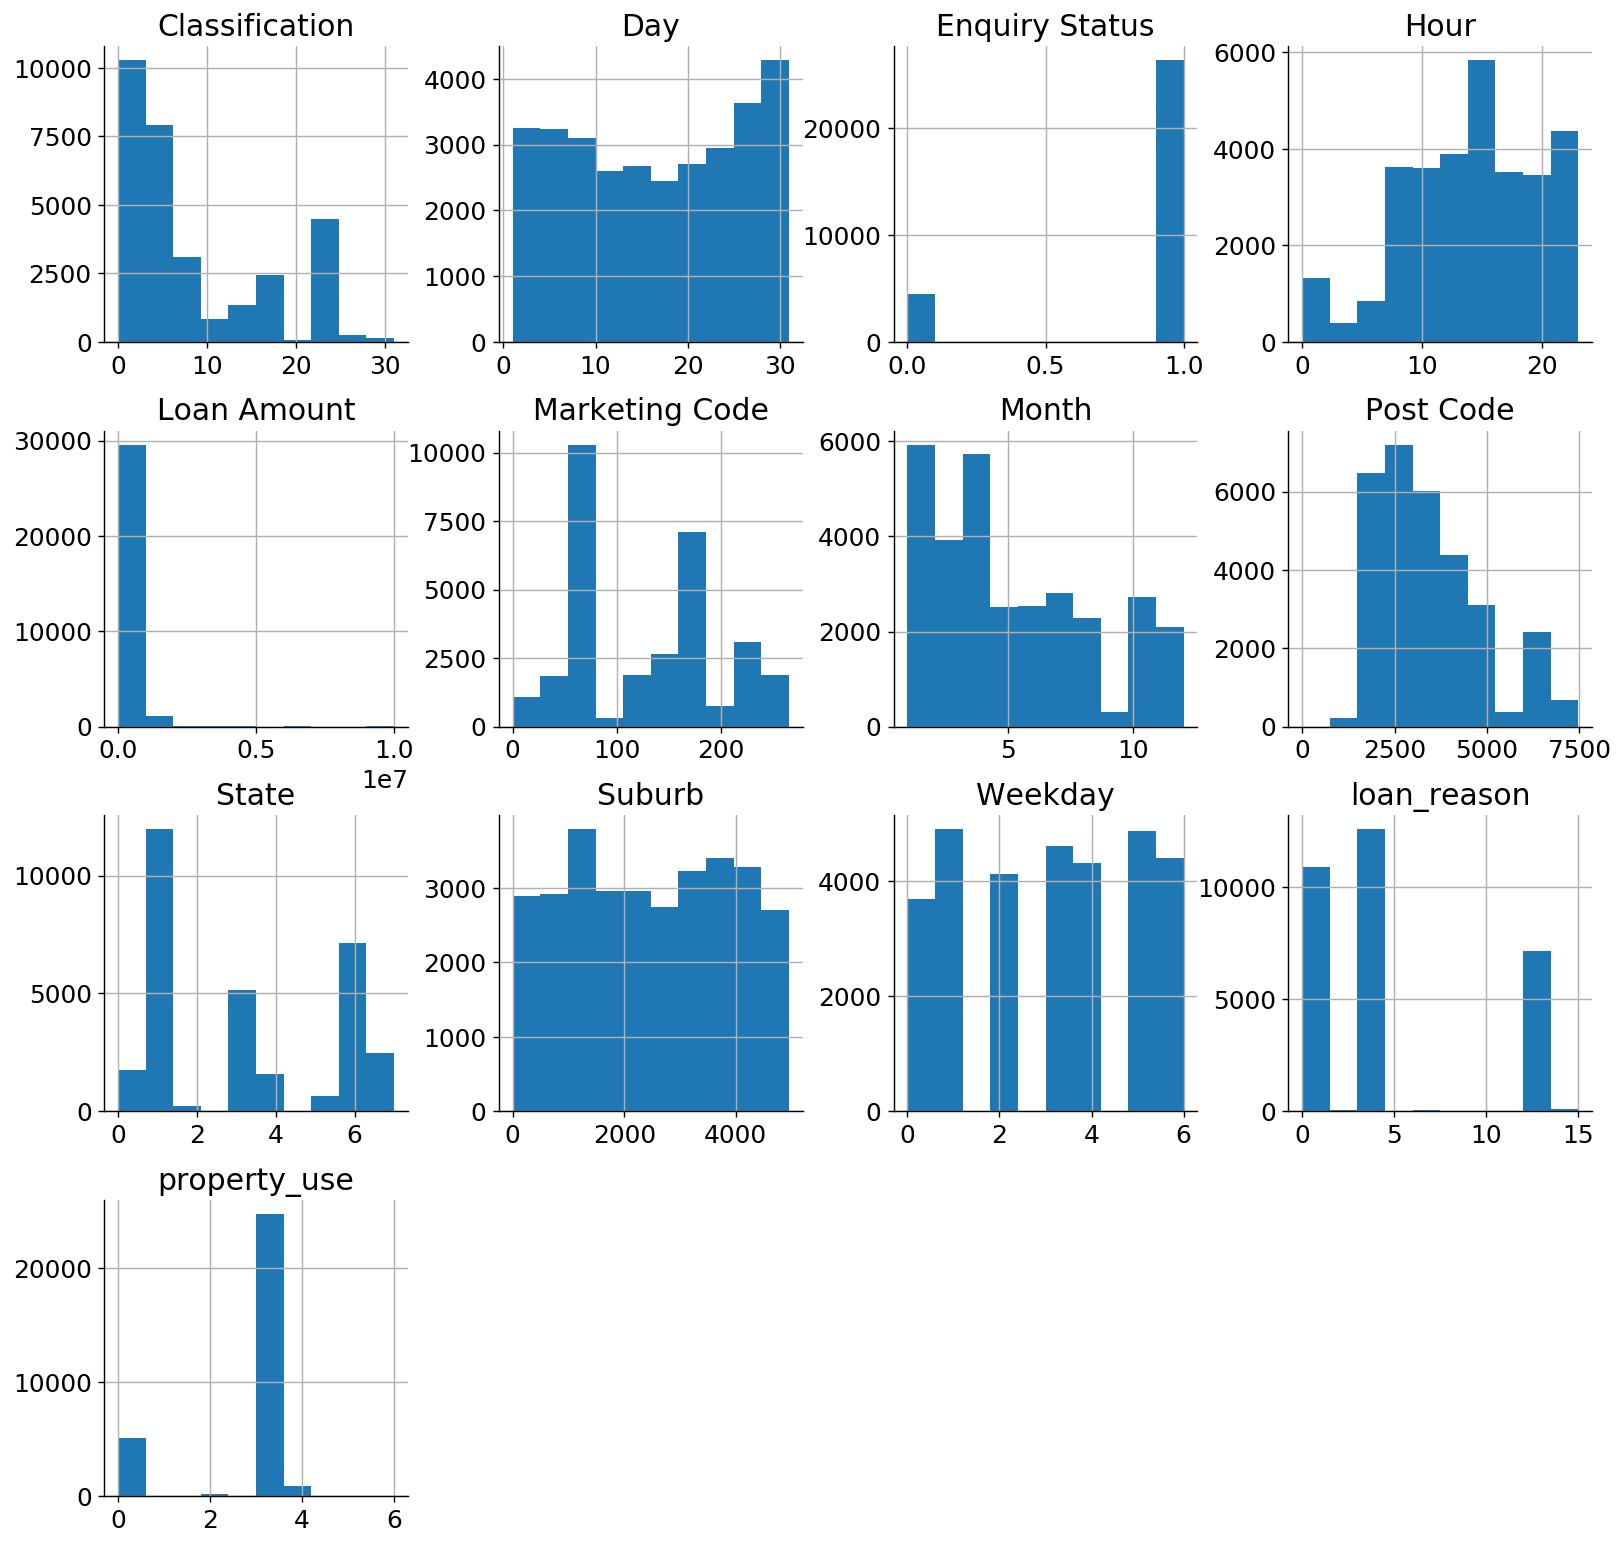

In [9]:
pd.DataFrame.hist(df, figsize = [15,15]);

In [10]:
# X = df[['Marketing Code','App Source', 'Web Source', 'Classification','Enquired Date',]]
X = df[df.keys()]
X = X.drop(['Enquiry Status'],1)
X = X.drop(['Enquired'],1)
y = df[target]

In [11]:
print("Keys of enquiries_dataset: \n{}".format(X.keys()))

Keys of enquiries_dataset: 
Index(['Marketing Code', 'Suburb', 'State', 'Post Code', 'Classification',
       'Loan Amount', 'loan_reason', 'property_use', 'Month', 'Day', 'Hour',
       'Weekday'],
      dtype='object')


In [12]:
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (30873, 12)
Shape of y: (30873,)


In [13]:
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
selected_X = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)
# rescale data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
print(lr.intercept_)
print(lr.coef_)

Training accuracy: 0.854657350423
Test accuracy: 0.854675016195
[ 1.81209433]
[[-0.06372902  0.          0.11312045  0.07253946 -0.17336435 -0.04273609
  -0.29237334  0.06311072  0.0230969   0.11349183 -0.03252935 -0.03935366]]


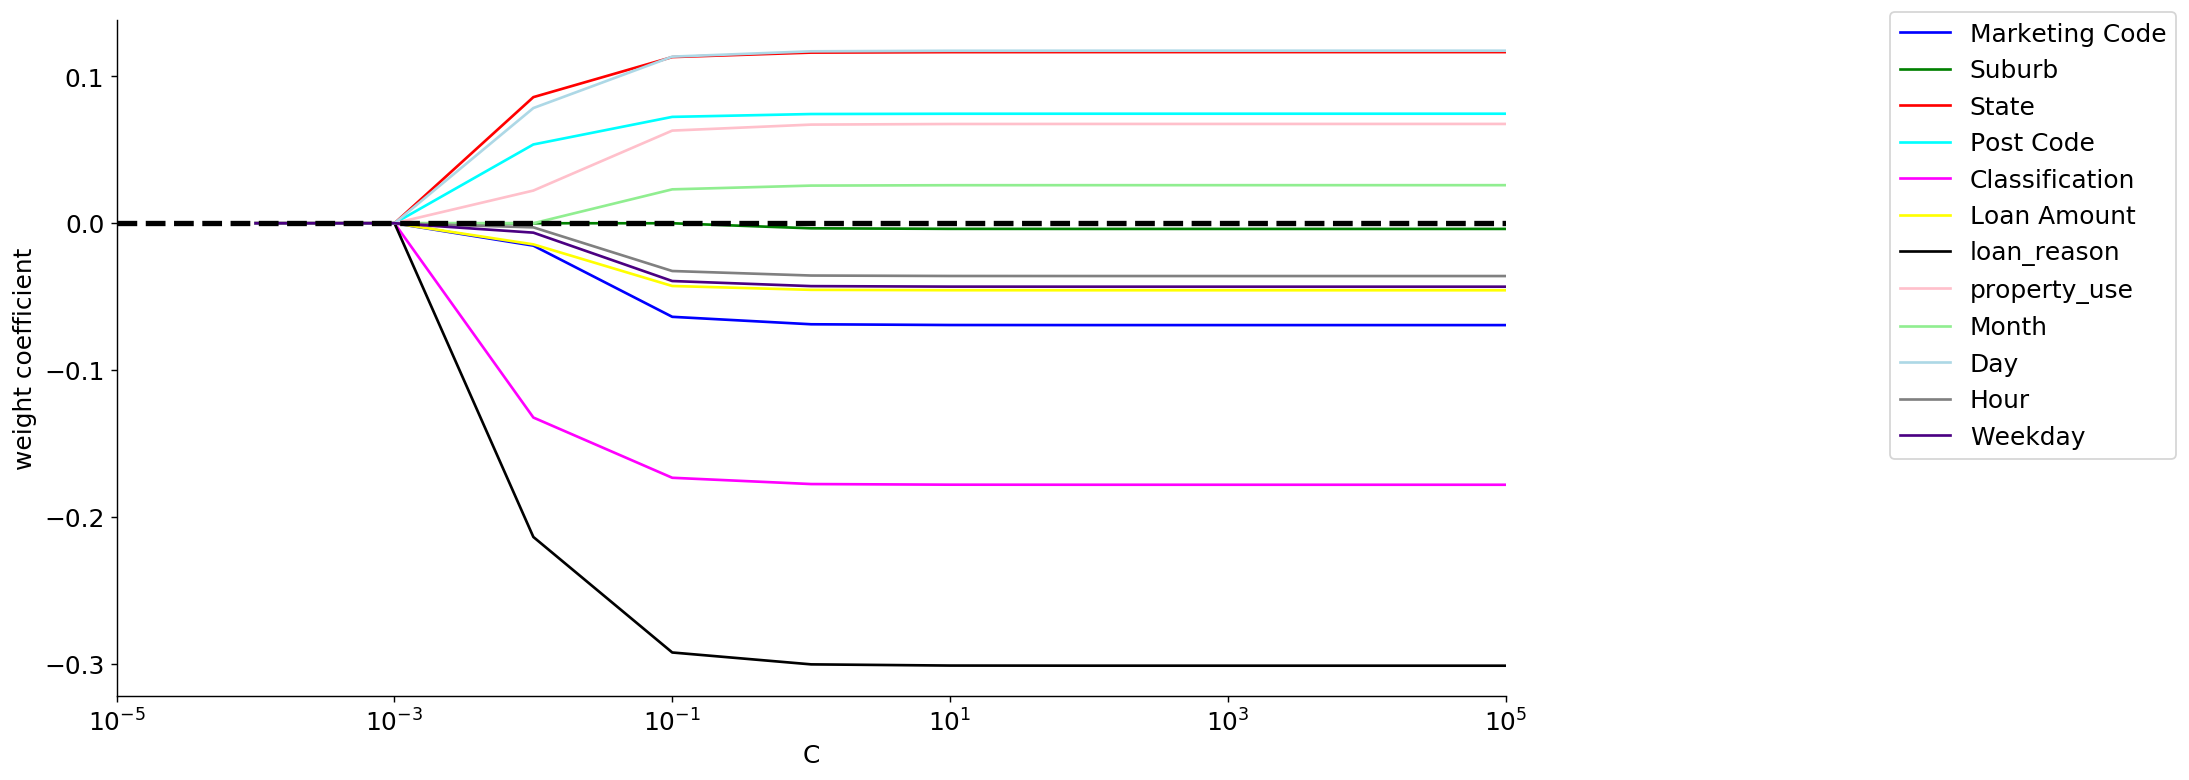

In [16]:
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan','magenta', 'yellow', 'black','pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10. ** c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10 ** c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=X.columns[column],
             color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

Test score: 0.86


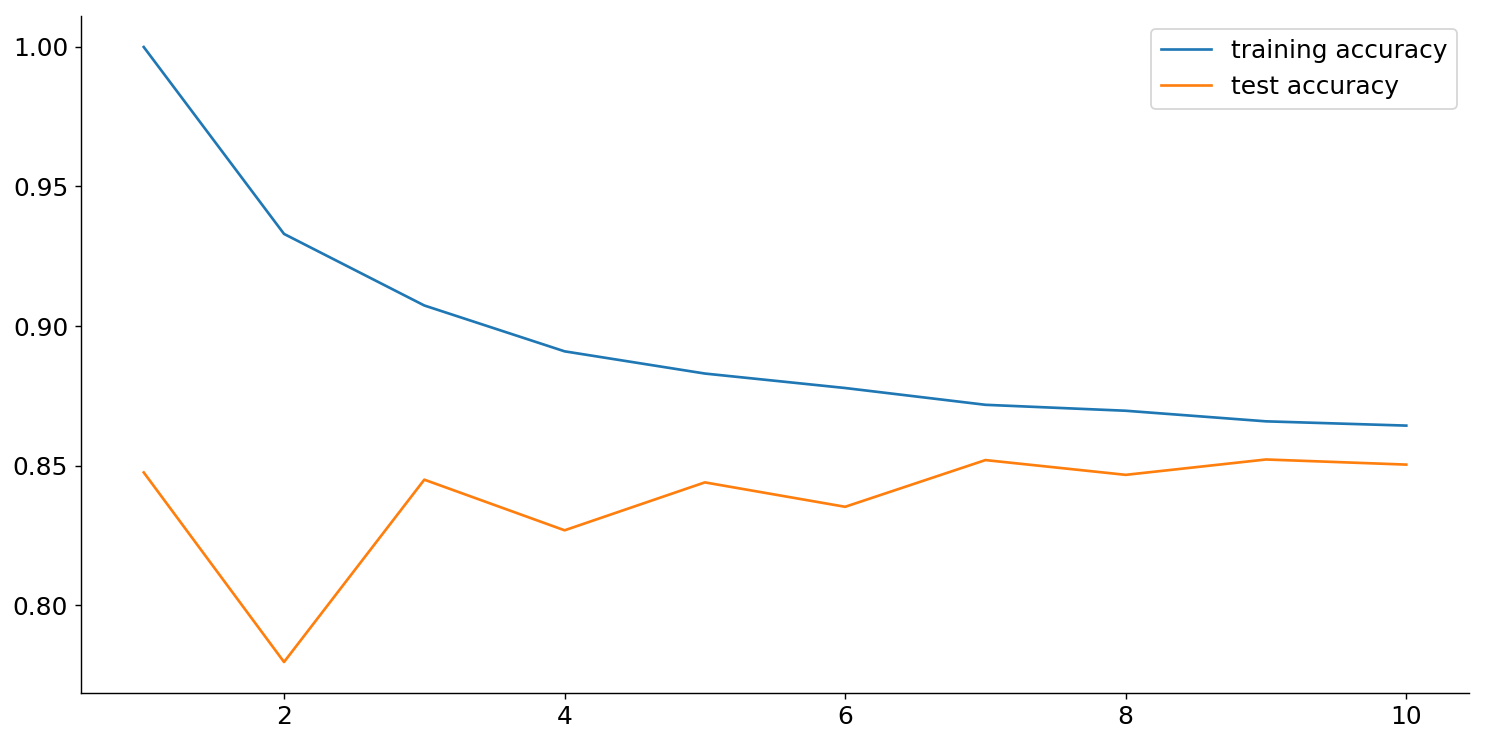

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_std, y_train)
pred_kn = knn.predict(X_test)
print("Test score: {:.2f}".format(knn.score(X_test_std, y_test)))


training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10.
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.legend()

In [18]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="hinge", penalty="l2")
sgd.fit(X_train_std, y_train)
pred_sgd = sgd.predict(X_test)
print("Test score: {:.2f}".format(sgd.score(X_test_std, y_test)))

Test score: 0.85


In [19]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train_std)
clf = SGDClassifier()  
clf.fit(X_train_std, y_train)
print("Test score: {:.2f}".format(clf.score(X_test_std, y_test)))

Test score: 0.85


In [20]:
from sklearn import svm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

svc = svm.SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print("Test score: {:.2f}".format(svc.score(X_test, y_test)))

scores = cross_val_score(clf, X, y, cv=5)

# N = range(1, 16)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test_std)
#     # Estimate accuracy on the data set with top n components
#     classifier = svm.SVC(gamma=0.001)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

Test score: 0.89


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train_std, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_std, y_test)))

scores = cross_val_score(rfc, X_test_std, y_test)

Test score: 0.91


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


lr = LogisticRegression()
lr = lr.fit(X_train_std, y_train)
pred_lr = lr.predict(X_test)

# pipe_lr = make_pipeline(PCA(n_components=2),LogisticRegression(random_state=1))

# lr = LogisticRegression(penalty='l1', C=0.1, random_state=0)
# lr.fit(X_train_std, y_train)
# pipe_lr.fit(X_train_std, y_train)
# y_pred = pipe_lr.predict(X_test)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.854657350423
Test accuracy: 0.854675016195


 1) Loan Amount                    0.131616
 2) Suburb                         0.130198
 3) Post Code                      0.122700
 4) Marketing Code                 0.113653
 5) loan_reason                    0.095707
 6) Day                            0.087966
 7) Hour                           0.082407
 8) Month                          0.059698
 9) Classification                 0.058517
10) Weekday                        0.053509
11) property_use                   0.035647
12) State                          0.028383


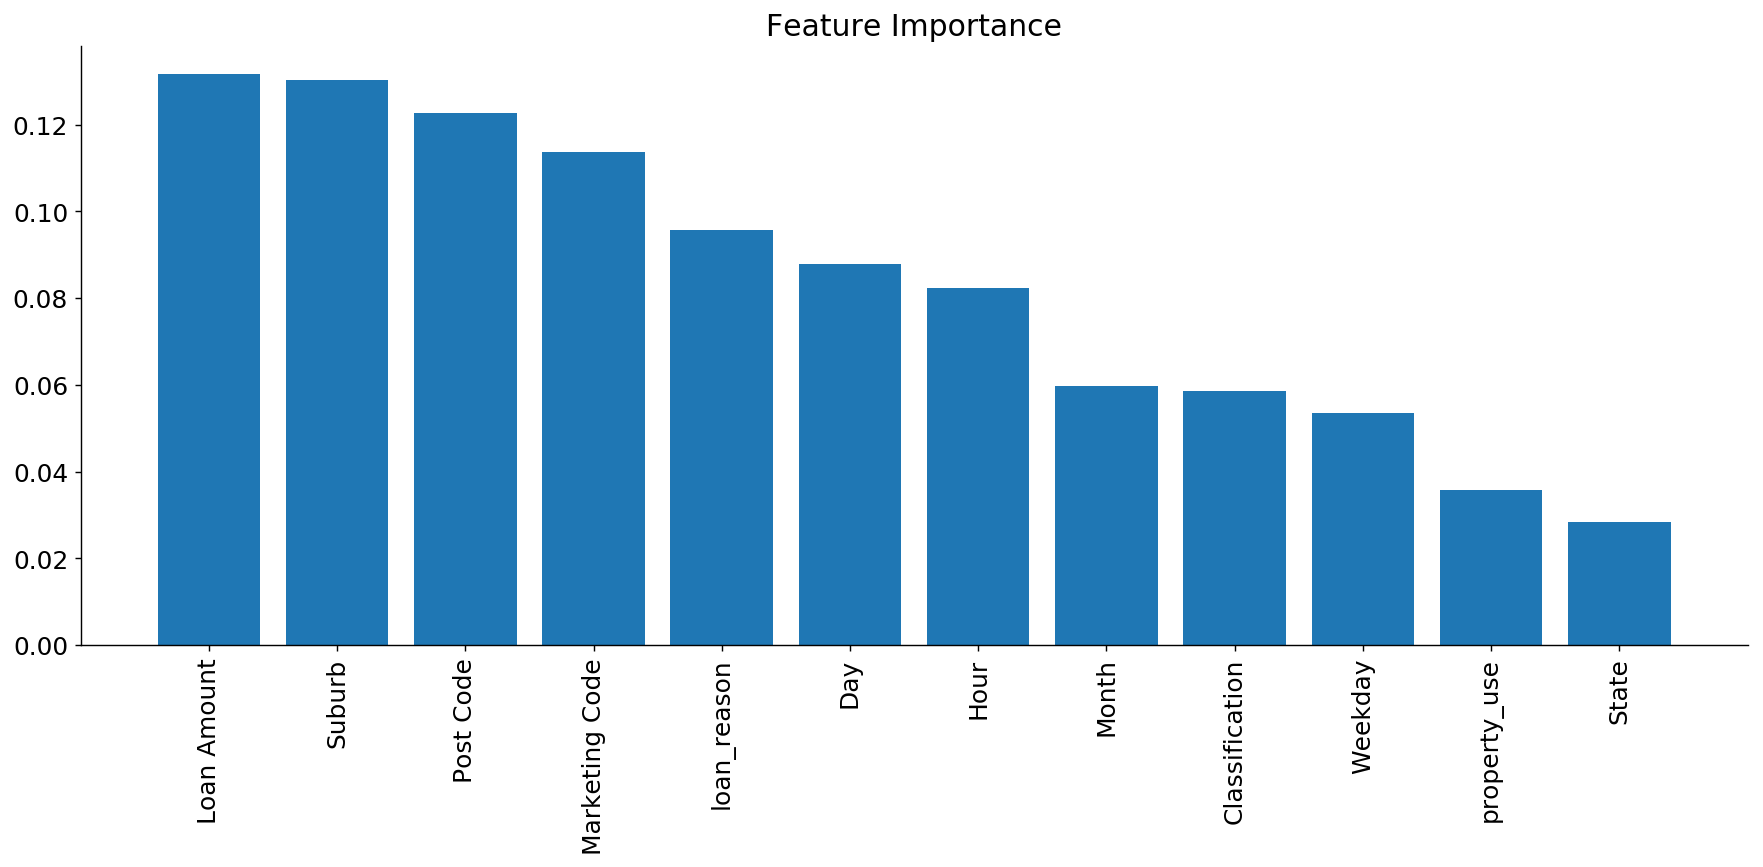

In [23]:
feat_labels = X.columns[:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

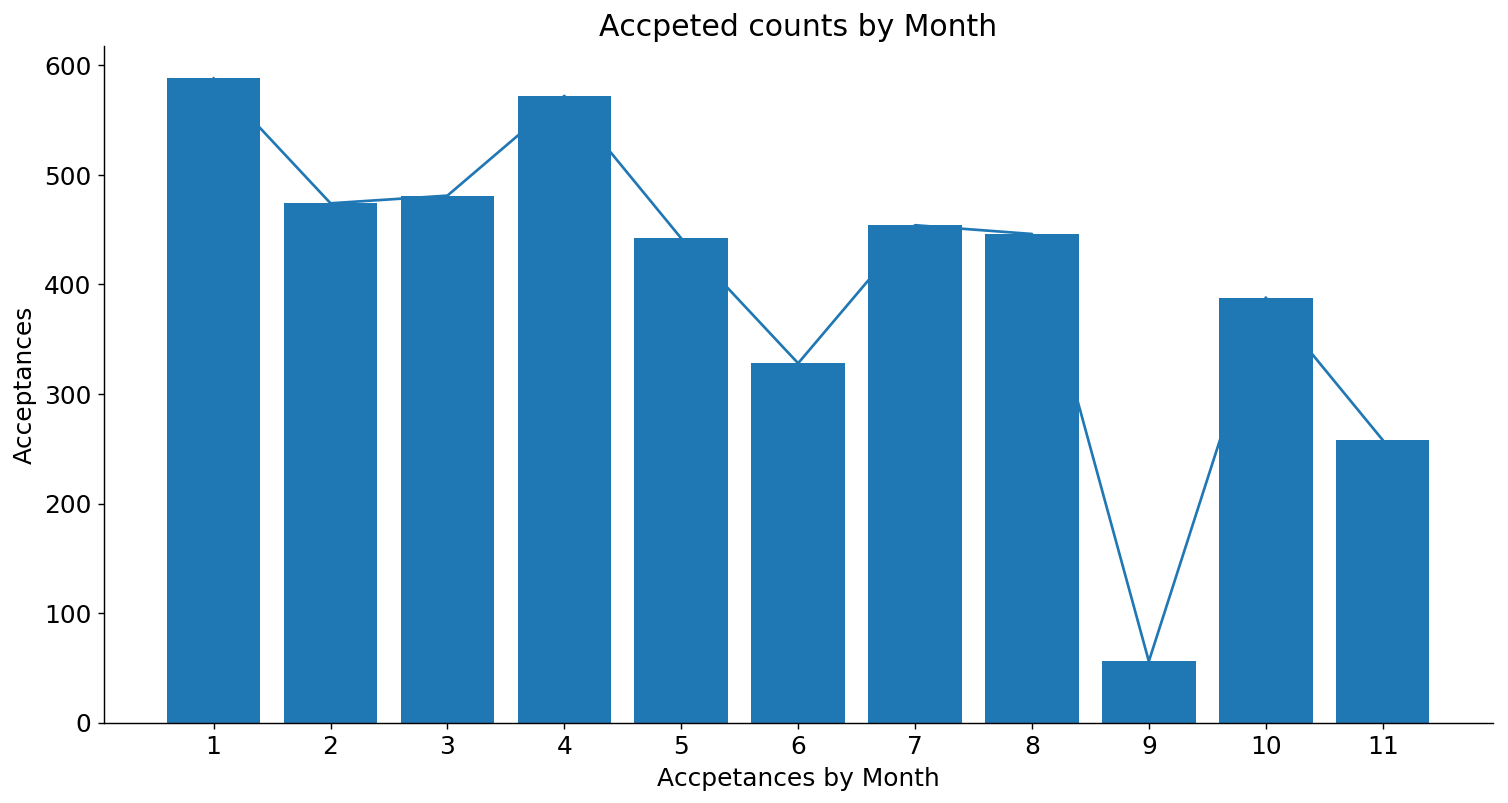

In [24]:
count_date_accepted = plt_accepted.groupby(['Month']).size().reset_index(name="counts")
count_date_rejected = plt_rejected.groupby(['Month']).size().reset_index(name="counts")

plt.plot(count_date_accepted['Month']-1, count_date_accepted['counts'])
plt.xlabel('Accpetances by Month')
plt.ylabel('Acceptances')

plt.title('Accpeted counts by Month')
plt.bar(range(count_date_accepted['Month'].shape[0]), count_date_accepted['counts'])
plt.xticks(range(count_date_accepted['Month'].shape[0]),count_date_accepted['Month'].values)
plt.show()

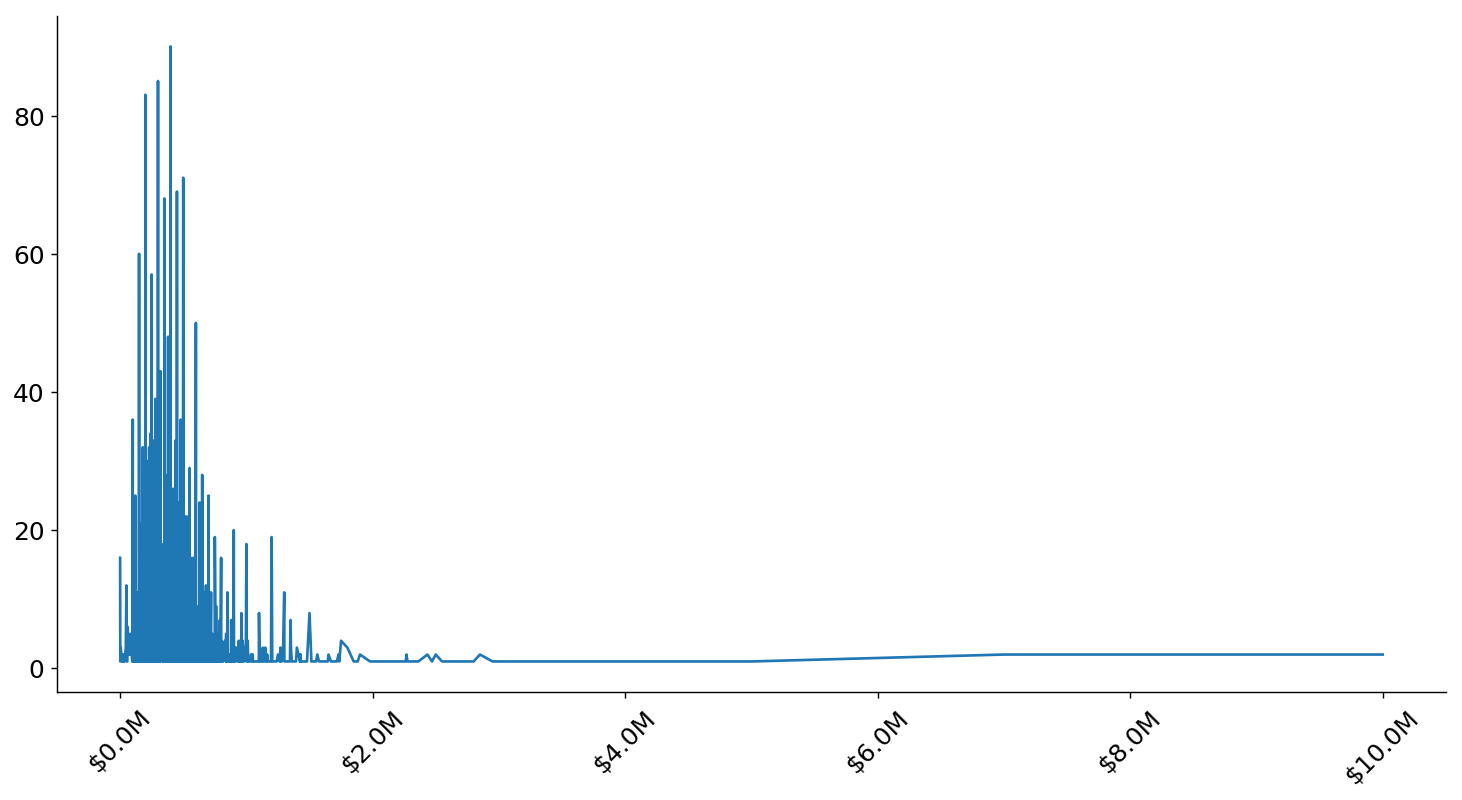

In [ ]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

count_amount_accepted = plt_accepted.groupby(['Loan Amount']).size().reset_index(name="counts")
count_amount_rejected = plt_rejected.groupby(['Loan Amount']).size().reset_index(name="counts")

# count_amount_accepted.to_csv('test.csv')
# display(count_amount_accepted)
fig, ax = plt.subplots()
plt.plot(count_amount_accepted['Loan Amount'], count_amount_accepted['counts'])
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
from sklearn import cross_validation
from sklearn.metrics import classification_report


scores = cross_validation.cross_val_score(lr, X, y, cv=5)
print("LogisticRegression cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

scores = cross_validation.cross_val_score(knn, X, y, cv=5)
print("KNeighborsClassifier cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

scores = cross_validation.cross_val_score(sgd, X, y, cv=5)
print("SGDClassifier cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

scores = cross_validation.cross_val_score(svc, X, y, cv=5)
print("SVC cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

scores = cross_validation.cross_val_score(rfc, X, y, cv=5)
print("RandomForestClassifier cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print()


print("LogisticRegression")
print(classification_report(y_test, pred_lr))

print("KNeighborsClassifier")
print(classification_report(y_test, pred_kn))

print("SGDClassifier")
print(classification_report(y_test, pred_sgd))

print("SVC")
print(classification_report(y_test, pred_svc))

print("RandomForestClassifier")
print(classification_report(y_test, pred_forest))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression cross_validation: 0.85
KNeighborsClassifier cross_validation: 0.85
SGDClassifier cross_validation: 0.85


In [ ]:
# input_x = X.iloc[:]
# input_x_test = X.iloc[:,idxs_selected]
# # input_x = input_x.iloc[0,idxs_selected]

# # input_x = input_x.drop('Enquiry Status', 1)

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# # for row in input_x:
# #     result = rfc.predict(row)[0]
# #     proba = np.max(rfc.predict_proba(row))    

# #     print('reuslt: {}'.format(le.inverse_transform(result)))
# #     print('probability: {0}%'.format(proba))
# #     print()

# # result = rfc.predict(input_x)[0]
# # proba = np.max(rfc.predict_proba(input_x))    

# # print('reuslt: {}'.format(le.inverse_transform(result)))
# # print('probability: {0}%'.format(proba))
# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]
# input_x.to_csv('example.csv')

In [ ]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.head()
# input_x.to_csv('result/v1.csv')

In [ ]:
a = '[{"col 1":"a","col 2":"b"},{"col 1":"c","col 2":"d"}]'

In [ ]:
# pd.read_json(a, orient='records')
# import json
# test_json = json.dumps(a)
test = pd.read_json(a, orient='records')
test